# Стилизация изображений (A Neural Algorithm of Artistic Style)

https://arxiv.org/abs/1508.06576

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19

print(tf.__version__)
print(tf.executing_eagerly())
print(tf.keras.backend.image_data_format())

2.7.0
True
channels_last


## Исходные изображения и параметры алгоритма

In [2]:
CONTENT_IMG_PATH = 'data/moscow.jpg'
STYLE_IMG_PATH = 'data/monet.jpg'

## Задаем размеры выходного изображения

In [3]:
# считываем размеры входного изображения
height, width = cv2.imread(CONTENT_IMG_PATH).shape[:-1]

# ограничиваем размер выходного изображения
# для ускорения процесса обработки
IMG_NROWS = min(400, height)
IMG_NCOLS = int(width * IMG_NROWS / height)

IMG_SHAPE = (IMG_NROWS, IMG_NCOLS, 3)

print('Output shape: %sx%sx%s' % IMG_SHAPE)

Output shape: 400x711x3


## Визуализируем исходные изображения

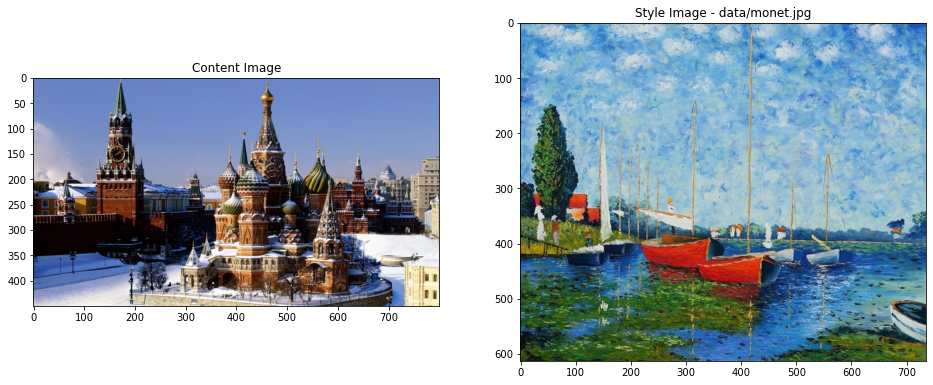

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(CONTENT_IMG_PATH)[...,::-1])
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(STYLE_IMG_PATH)[...,::-1])
plt.title('Style Image - %s' % STYLE_IMG_PATH)

plt.show()

## Функции предобработки изображений

In [5]:
# препроцессинг изображения для отправки в сеть vgg19
def preprocess_image(path):
    # все изображения приводятся к одному размеру для ускорения обработки батчем
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, dsize=(IMG_NCOLS, IMG_NROWS))
    # применяем предобработку vgg19 
    img = vgg19.preprocess_input(img, data_format='channels_last')
    return np.expand_dims(img, axis=0)  # добавляем измерение батча

# восстанавливаем изображение после предобработки vgg19
def deprocess_image(x):
    x = x.reshape(IMG_SHAPE)
    # возвращаем смещение относительно среднего (препроцессинг vgg19)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Загружаем предобученную сеть

In [6]:
feature_extractor = vgg19.VGG19(weights='imagenet',
                                input_shape=IMG_SHAPE,
                                include_top=False)

feature_extractor.summary()

80150528/80134624 [==============================] - 9s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 711, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 711, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 711, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 355, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 355, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 355, 128)     147584    
                                                              

## Определяем выходы для копировния стиля и содержания

In [7]:
CONTENT_LAYERS = ['block5_conv2']

STYLE_LAYERS = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

content_outputs = [feature_extractor.get_layer(layer).output
                   for layer in CONTENT_LAYERS]

style_outputs = [feature_extractor.get_layer(layer).output
                  for layer in STYLE_LAYERS]

feature_extractor.trainable = False

model = tf.keras.Model(inputs=feature_extractor.input,
                       outputs={'style': style_outputs,
                                'content': content_outputs})

## Задаем функцию потерь

In [8]:
STYLE_WEIGHT = 1e-2
CONTENT_WEIGHT = 1e4

# матрица ковариации
def gram_matrix(features):
    # assert tf.rank(features) == 3
    features = tf.transpose(features, (2, 0, 1))
    features = tf.keras.backend.batch_flatten(features)
    # вычисляем ковариации между каналами
    gram = tf.matmul(features, features, transpose_b=True)
    return gram / features.shape[-1]

# функция потерь для стиля вычисляется на основе матрицы ковариации
def style_loss(style, result):
    gram_style = gram_matrix(style)
    gram_result = gram_matrix(result)
    return tf.reduce_mean((gram_style - gram_result) ** 2)

# функция потерь для содержания
def content_loss(content, result):
    return tf.reduce_mean((content - result) ** 2)

@tf.function
def train_step(content_image, style_image, result_image):
    with tf.GradientTape() as g:
        # объединяем изображения в батч
        input_batch = tf.concat([content_image,
                                 style_image,
                                 result_image], axis=0)
        
        # получаем значения на промежуточных
        # слоях VGG для каждого из изображений
        outputs = model(input_batch)
        
        # вычисляем значение функции потерь
        content_losses = [content_loss(out[0], out[2])
                          for out in outputs['content']]
        
        style_losses = [style_loss(out[1], out[2])
                        for out in outputs['style']]
        
        loss = CONTENT_WEIGHT * tf.math.add_n(content_losses) / len(content_losses)
        loss += STYLE_WEIGHT * tf.math.add_n(style_losses) / len(style_losses)
    
    # возвращаем значение функции потерь и 
    # градиенты для результирующего изображения
    return loss, g.gradient(loss, result_image)

## Загружаем изображения для обработки

In [9]:
# Функция для визуализация обрабатываемых изображений
def show_images(content_image, style_image, result_image, horizontal=True):
    rows, cols = (1, 3) if horizontal else (3, 1)
    
    plt.figure(figsize=(18, 18))
    plt.subplot(rows, cols, 1)
    plt.imshow(deprocess_image(content_image.numpy()))
    plt.title('Content')

    plt.subplot(rows, cols, 2)
    plt.imshow(deprocess_image(style_image.numpy()))
    plt.title('Style')

    plt.subplot(rows, cols, 3)
    plt.imshow(deprocess_image(result_image.numpy()))
    plt.title('Result')

    plt.show()

In [10]:
# загружаем изображения и подготоваливаем к прогону через vgg
content_image = preprocess_image(CONTENT_IMG_PATH)
content_image = tf.constant(content_image, name='content')

style_image = preprocess_image(STYLE_IMG_PATH)
style_image = tf.constant(style_image, name='style')

# инициализируем результирующее изображение исходным
result_image = preprocess_image(CONTENT_IMG_PATH)
result_image = tf.Variable(result_image, name='result')

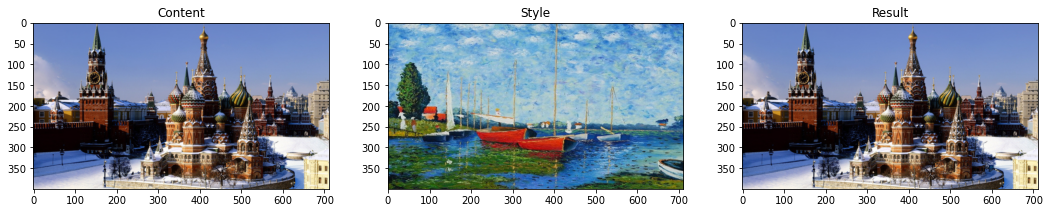

In [11]:
# визуализируем загруженные изображения
show_images(content_image, style_image, result_image)

## Запускаем процесс обучения

In [12]:
# инициализируем оптимизатор
opt = tf.optimizers.Adam(learning_rate=0.75, beta_1=0.99, epsilon=1e-1)

In [13]:
ITERATIONS = 15
for i in range(ITERATIONS):
    # определяем значение функции потерь и градиенты для результирующего изображения
    loss, grad = train_step(content_image, style_image, result_image)
    step = opt.apply_gradients([(grad, result_image)])
    print('[%03d] %.3f' % (step, loss))

[001] 215857088.000
[002] 170664416.000
[003] 139129840.000
[004] 115760648.000
[005] 97984608.000
[006] 84306408.000
[007] 73649544.000
[008] 65227304.000
[009] 58450220.000
[010] 52910520.000
[011] 48323248.000
[012] 44509724.000
[013] 41365056.000
[014] 38825616.000
[015] 36841040.000


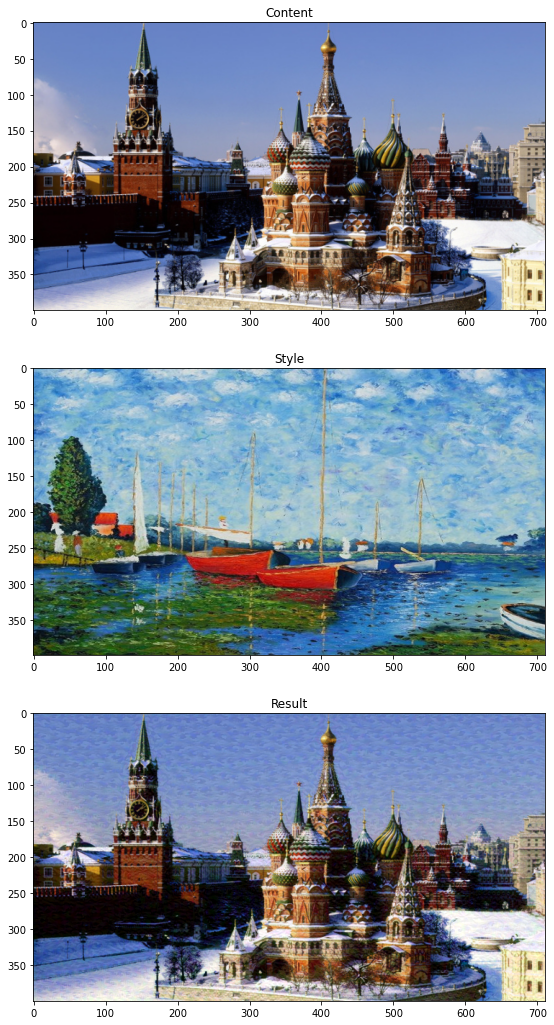

In [14]:
# визуализируем результат
show_images(content_image, style_image, result_image, horizontal=False)

## Примеры работы

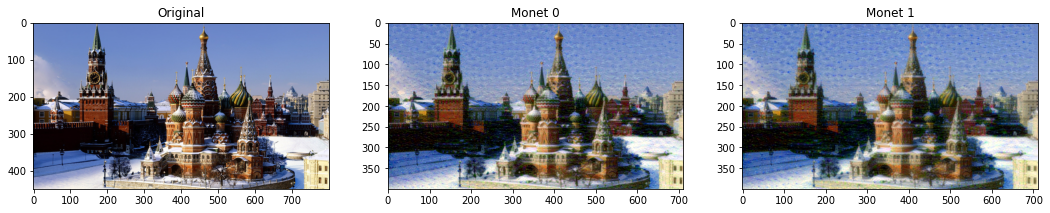

In [15]:
plt.figure(figsize=(18, 10))

plt.subplot(1, 3, 1)
plt.imshow(cv2.imread('./data/moscow.jpg')[...,::-1])
plt.title('Original');

plt.subplot(1, 3, 2)
plt.imshow(plt.imread('./data/styled_monet_0.png'))
plt.title('Monet 0');

plt.subplot(1, 3, 3)
plt.imshow(plt.imread('./data/styled_monet_1.png'))
plt.title('Monet 1');

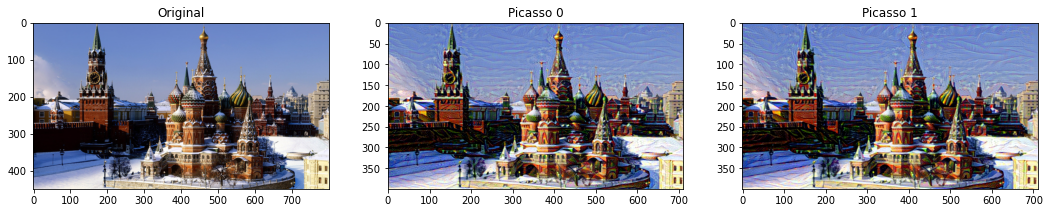

In [16]:
plt.figure(figsize=(18, 10))

plt.subplot(1, 3, 1)
plt.imshow(cv2.imread('./data/moscow.jpg')[...,::-1])
plt.title('Original');

plt.subplot(1, 3, 2)
plt.imshow(plt.imread('./data/styled_picasso_0.png'))
plt.title('Picasso 0');

plt.subplot(1, 3, 3)
plt.imshow(plt.imread('./data/styled_picasso_1.png'))
plt.title('Picasso 1');